In [19]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
NUM_FOLDS = 5
MAX_SEQ_LENGTH = 70  # Fixed sequence length from your dataset

notebook_dir = Path.cwd()
BASE_DIR = notebook_dir.parent

DATA_PATH = BASE_DIR / "data" / "aufgabe3"
DATA_PATH_FOLDS = DATA_PATH / "5-fold"
MODEL_SAVE_PATH_TEMP = str(BASE_DIR / "models" / "6state_ohe_lstm_cnn_fold{}.pt")
MODEL_SAVE_PATH = BASE_DIR / "models" / "6state_ohe_lstm_cnn.pt"
TRAIN_VAL_LOSSES_DATA_SAVE_PATH = DATA_PATH / "outputs"
TEST_CSV = DATA_PATH / "reduced_30_signalP6_test.csv"

(BASE_DIR / "models").mkdir(exist_ok=True)
(DATA_PATH / "outputs").mkdir(exist_ok=True)

print(f"Project base directory set to: {BASE_DIR}")
print(f"Data path set to: {DATA_PATH}")
print(f"Model save path set to: {MODEL_SAVE_PATH}")

# One-hot encoding setup (from 2-state model)
aas = 'ARNDCEQGHILKMFPSTWYV'
aa2idx = {aa: i for i, aa in enumerate(aas)}
idx2aa = {i: aa for aa, i in aa2idx.items()}
num_aa = len(aas)
print(f"Number of amino acids: {num_aa}")

Using device: mps
Project base directory set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction
Data path set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3
Model save path set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn.pt
Number of amino acids: 20


In [20]:

print("Loading test data...")
test_df = pd.read_csv(TEST_CSV)
print(f"Test records: {len(test_df)}")

test_df.head()


Loading test data...
Test records: 3419


,uniprot_id,kingdom,type,sequence,labels,length,has_sp
0,B2VGX7,NEGATIVE,TAT,MKAVNPLTENDVTPESLFNARRRTVLKMLGMSAAALSLPGAARADL...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOO...,70,True
1,Q9DEN4,EUKARYA,NO_SP,MTLSGSGSASDMSGQTVLSADDADIDVVGEGDEALDKDSECESTAG...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
2,A9QM74,EUKARYA,NO_SP,MPTLDAPEERRRKFKYRGKDVSLRRQQRMAVSLELRKAKKDEQTLK...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
3,Q8K3I4,EUKARYA,NO_SP,MGRKLDLSGLTDDETEHVLQVVQRDFNLRKKEEDRLSEMKQRLAEE...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
4,Q920M2,EUKARYA,NO_SP,MEVPELGPGLVERLEQLATCPLCGGPFEDPVLLACEHSFCRSCLAR...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False


In [21]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

def one_hot_encode_sequence(sequence, max_length=MAX_SEQ_LENGTH):
    """One-hot encode a protein sequence"""
    encoding = np.zeros((max_length, num_aa), dtype=np.float32)
    
    for i, aa in enumerate(sequence):
        if i >= max_length:
            break
        if aa in aa2idx:
            encoding[i, aa2idx[aa]] = 1.0
        # Unknown amino acids remain as zero vectors
    
    return encoding

print("\nProcessing test data...")
test_df_filtered = test_df[~test_df["labels"].str.contains("P", na=False)]
print(f"Test records after filtering: {len(test_df_filtered)}")

test_df_filtered.describe()

test_df_encoded = test_df_filtered.copy()
test_df_encoded["label"] = test_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
test_df_encoded = test_df_encoded[test_df_encoded["label"].map(len) > 0]
test_seqs = test_df_encoded["sequence"].tolist()
test_label_seqs = test_df_encoded["label"].tolist()

print(f"Test sequences: {len(test_seqs)}")
test_df_encoded.describe()


Processing test data...
Test records after filtering: 3412
Test sequences: 3412


,length
count,3412.0
mean,70.0
std,0.0
min,70.0
25%,70.0
50%,70.0
75%,70.0
max,70.0


In [22]:
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        labels = self.label_seqs[idx]
        
        # One-hot encode the sequence
        encoded_seq = one_hot_encode_sequence(seq, MAX_SEQ_LENGTH)
        
        # Create attention mask (1 for actual sequence, 0 for padding)
        attention_mask = np.zeros(MAX_SEQ_LENGTH, dtype=np.float32)
        seq_len = min(len(seq), MAX_SEQ_LENGTH)
        attention_mask[:seq_len] = 1.0
        
        # Pad or truncate labels to match MAX_SEQ_LENGTH
        token_labels = np.full(MAX_SEQ_LENGTH, -100, dtype=np.int64)
        for i, label in enumerate(labels):
            if i >= MAX_SEQ_LENGTH:
                break
            token_labels[i] = label
        
        return {
            'encoded_seq': torch.tensor(encoded_seq, dtype=torch.float32),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.float32),
            'labels': torch.tensor(token_labels, dtype=torch.long)
        }

# Test dataset
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTest data prepared: {len(test_seqs)} sequences")
print(f"One-hot encoding shape: ({MAX_SEQ_LENGTH}, {num_aa})")


Test data prepared: 3412 sequences
One-hot encoding shape: (70, 20)


In [23]:
!pip install pytorch-crf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, num_aa, num_labels, hidden_dim=512):
        super().__init__()
        self.num_aa = num_aa
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.35)
        
        # Input: one-hot encoded sequences (batch, seq_len, num_aa=20)
        # Need to project to higher dimension for CNN
        self.input_projection = nn.Linear(num_aa, hidden_dim)
        
        # CNN layer (similar to original but adjusted for smaller input)
        self.conv = nn.Conv1d(in_channels=hidden_dim, out_channels=1024, kernel_size=5, padding=2)
        self.bn_conv = nn.BatchNorm1d(1024)
        
        # BiLSTM
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        
        # Classifier
        self.classifier = nn.Linear(512 * 2, num_labels)
        
        # CRF
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, encoded_seq, attention_mask, labels=None):
        # encoded_seq: (batch, seq_len, num_aa)
        batch_size = encoded_seq.size(0)
        
        # Project one-hot encoding to higher dimension
        x = self.input_projection(encoded_seq)  # (batch, seq_len, hidden_dim)
        
        # Apply conv (requires channels first)
        x_conv = self.conv(x.transpose(1, 2))  # (batch, 1024, seq_len)
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu_(x_conv)
        
        # Transpose for LSTM
        x_lstm_input = x_conv.transpose(1, 2)  # (batch, seq_len, 1024)
        
        # Apply LSTM
        lstm_out, _ = self.lstm(x_lstm_input)  # (batch, seq_len, 1024)
        
        # Classifier
        x_linear = self.classifier(lstm_out)  # (batch, seq_len, num_labels)
        logits = self.dropout(x_linear)
        
        if labels is not None:
            # Create CRF mask
            crf_mask = (labels != -100) & (attention_mask.bool())
            
            # Replace -100 with 0 for CRF compatibility
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            
            loss = -self.crf(logits, mod_labels, mask=crf_mask, reduction='mean')
            return loss
        else:
            # Decode only valid positions
            crf_mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=crf_mask)
            return predictions

print("\nModel architecture:")
print(f"  Input: One-hot encoded sequences ({MAX_SEQ_LENGTH}, {num_aa})")
print(f"  Projection: {num_aa} → 512")
print(f"  CNN: 512 → 1024 (kernel=5)")
print(f"  BiLSTM: 1024 → 512×2 (2 layers)")
print(f"  Classifier: 1024 → {NUM_CLASSES}")
print(f"  CRF: {NUM_CLASSES} states")


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

Model architecture:
  Input: One-hot encoded sequences (70, 20)
  Projection: 20 → 512
  CNN: 512 → 1024 (kernel=5)
  BiLSTM: 1024 → 512×2 (2 layers)
  Classifier: 1024 → 6
  CRF: 6 states


In [24]:
from transformers import get_linear_schedule_with_warmup

# load and prepare data for a specific fold
def prepare_fold_data(fold_num):

    train_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_train.csv")
    val_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_val.csv")

    print(f"\n=== Fold {fold_num} ===")
    print(f"Loading training data from: {train_csv}")
    train_df = pd.read_csv(train_csv)
    print(f"Training records: {len(train_df)}")
    print(train_df['type'].value_counts())

    print(f"Loading validation data from: {val_csv}")
    val_df = pd.read_csv(val_csv)
    print(f"Validation records: {len(val_df)}")

    # Filter data
    train_df_filtered = train_df[~train_df["labels"].str.contains("P", na=False)]
    val_df_filtered = val_df[~val_df["labels"].str.contains("P", na=False)]
    print(f"Training records after filtering: {len(train_df_filtered)}")
    print(f"Validation records after filtering: {len(val_df_filtered)}")

    # Encode labels
    train_df_encoded = train_df_filtered.copy()
    train_df_encoded["label"] = train_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    train_df_encoded = train_df_encoded[train_df_encoded["label"].map(len) > 0]
    train_seqs = train_df_encoded["sequence"].tolist()
    train_label_seqs = train_df_encoded["label"].tolist()
    print("Encoded train data:")
    train_df_encoded.head()

    val_df_encoded = val_df_filtered.copy()
    val_df_encoded["label"] = val_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    val_df_encoded = val_df_encoded[val_df_encoded["label"].map(len) > 0]
    val_seqs = val_df_encoded["sequence"].tolist()
    val_label_seqs = val_df_encoded["label"].tolist()

    # Create datasets
    train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
    val_dataset = SPDataset(val_seqs, val_label_seqs, label_map)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Fold {fold_num} prepared: {len(train_seqs)} train, {len(val_seqs)} val sequences")

    return train_loader, val_loader, train_seqs, val_seqs

In [25]:
# sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


In [26]:
# Count model parameters
def count_parameters(model):
    """Count total and trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*60}")
    print("MODEL PARAMETER COUNT")
    print(f"{'='*60}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print(f"{'='*60}\n")
    
    return total_params, trainable_params

# Create a model instance and count parameters
model_temp = SPCNNClassifier(num_aa, NUM_CLASSES).to(DEVICE)

total, trainable = count_parameters(model_temp)


MODEL PARAMETER COUNT
Total parameters: 15,240,758
Trainable parameters: 15,240,758
Non-trainable parameters: 0



In [27]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import gc
import matplotlib.pyplot as plt
import pickle

# Store results for all folds
fold_results = {
    'train_losses': [],
    'val_losses': [],
    'best_val_losses': [],
    'fold_numbers': []
}

# Cross Validation Training Loop
for fold in range(1, NUM_FOLDS + 1):
    print(f"\n{'='*60}")
    print(f"Starting Fold {fold}/{NUM_FOLDS}")
    print(f"{'='*60}")

    # Prepare data for this fold
    train_loader, val_loader, train_seqs, val_seqs = prepare_fold_data(fold)

    # Initialize fresh model for each fold (no encoder to unfreeze!)
    model = SPCNNClassifier(num_aa, NUM_CLASSES).to(DEVICE)

    # Optimizer - all layers train from the start
    optimizer = torch.optim.AdamW([
        {"params": model.input_projection.parameters(), "lr": 1e-3},
        {"params": model.conv.parameters(), "lr": 1e-3},
        {"params": model.classifier.parameters(), "lr": 1e-3},
        {"params": model.lstm.parameters(), "lr": 1e-3},
        {"params": model.crf.parameters(), "lr": 1e-3},
    ])

    scaler = GradScaler()

    # Track losses for this fold
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 4
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(EPOCHS):

        # Create scheduler for epoch
        total_steps = len(train_loader)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
        total_train_loss = 0

        for batch in pbar:
            try:
                encoded_seq = batch['encoded_seq'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                optimizer.zero_grad()

                loss = model(encoded_seq, attention_mask, token_labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            except RuntimeError as e:
                print("Error during training:", e)
                gc.collect()
                continue

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_batches = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch"):
                encoded_seq = batch['encoded_seq'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                loss = model(encoded_seq, attention_mask, token_labels)
                total_val_loss += loss.item()
                val_batches += 1

        avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)

        print(f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model for fold (temporary)
        if avg_val_loss < best_val_loss:
            patience_counter = 0
            best_val_loss = avg_val_loss
            model_path_temp = MODEL_SAVE_PATH_TEMP.format(fold)
            torch.save(model.state_dict(), model_path_temp)
            print(f"  → Best model for fold {fold} saved to {model_path_temp}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                break

    # Store results for fold
    fold_results['train_losses'].append(train_losses)
    fold_results['val_losses'].append(val_losses)
    fold_results['best_val_losses'].append(best_val_loss)
    fold_results['fold_numbers'].append(fold)

    print(f"\nBest validation loss for fold {fold}: {best_val_loss:.4f}")


print("\n" + "="*60)
print("K-Fold Cross Validation Complete!")
print("="*60)

print("\nSummary of all folds:")
for i, best_loss in enumerate(fold_results['best_val_losses'], 1):
    print(f"Fold {i}: Best Validation Loss = {best_loss:.4f}")

avg_best_val_loss = sum(fold_results['best_val_losses']) / NUM_FOLDS
print(f"\nAverage Best Validation Loss across all folds: {avg_best_val_loss:.4f}")

# Find best fold
best_fold_idx = fold_results['best_val_losses'].index(min(fold_results['best_val_losses']))
best_fold_num = fold_results['fold_numbers'][best_fold_idx]
best_fold_loss = fold_results['best_val_losses'][best_fold_idx]

print(f"\n{'='*60}")
print(f"Best performing fold: Fold {best_fold_num}")
print(f"Best validation loss: {best_fold_loss:.4f}")
print(f"{'='*60}")

# best model saved to MODEL_SAVE_PATH
import shutil
best_model_path = MODEL_SAVE_PATH_TEMP.format(best_fold_num)
shutil.copy(best_model_path, MODEL_SAVE_PATH)
print(f"\nBest model (Fold {best_fold_num}) saved to: {MODEL_SAVE_PATH}")

# clean up of temporary fold models
print("\nTemporary fold models:")
for i in range(1, NUM_FOLDS + 1):
    temp_path = MODEL_SAVE_PATH_TEMP.format(i)
    if os.path.exists(temp_path):
        print(f"  - {temp_path}")

os.makedirs(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, exist_ok=True)
losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "train_val_losses.pkl")

losses_data = {
    'fold_numbers': fold_results['fold_numbers'],
    'train_losses': fold_results['train_losses'],
    'val_losses': fold_results['val_losses'],
    'best_val_losses': fold_results['best_val_losses'],
    'best_fold_num': best_fold_num,
    'best_fold_loss': best_fold_loss,
    'avg_best_val_loss': avg_best_val_loss,
    'epochs': EPOCHS,
    'num_folds': NUM_FOLDS
}

with open(losses_pickle_path, 'wb') as f:
    pickle.dump(losses_data, f)

print(f"\nTraining and validation losses saved to: {losses_pickle_path}")
print(f"Data structure:")
print(f"  - fold_numbers: list of fold IDs")
print(f"  - train_losses: list of training losses per fold (each fold has {EPOCHS} epochs)")
print(f"  - val_losses: list of validation losses per fold (each fold has {EPOCHS} epochs)")
print(f"  - best_val_losses: list of best validation loss for each fold")
print(f"  - best_fold_num: {best_fold_num}")
print(f"  - best_fold_loss: {best_fold_loss:.4f}")
print(f"  - avg_best_val_loss: {avg_best_val_loss:.4f}")


Starting Fold 1/5

=== Fold 1 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_1_train.csv
Training records: 10940
type
NO_SP      9082
SP         1295
LIPO        424
TAT         103
PILIN        24
TATLIPO      12
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_1_val.csv
Validation records: 2735
Training records after filtering: 10916
Validation records after filtering: 2732


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_44211/396588932.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Encoded train data:
Fold 1 prepared: 10916 train, 2732 val sequences


Fold 1 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 11.99batch/s]


Fold 1 - Epoch 1/10 - Train Loss: 46.4558, Val Loss: 13.5608
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.11batch/s]


Fold 1 - Epoch 2/10 - Train Loss: 32.8202, Val Loss: 11.0163
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.97batch/s]


Fold 1 - Epoch 3/10 - Train Loss: 27.1631, Val Loss: 9.1988
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.07batch/s]


Fold 1 - Epoch 4/10 - Train Loss: 22.1493, Val Loss: 8.2339
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.96batch/s]


Fold 1 - Epoch 5/10 - Train Loss: 18.4652, Val Loss: 7.8298
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.15batch/s]


Fold 1 - Epoch 6/10 - Train Loss: 15.6931, Val Loss: 7.1172
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.15batch/s]


Fold 1 - Epoch 7/10 - Train Loss: 12.7343, Val Loss: 6.5596
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.09batch/s]


Fold 1 - Epoch 8/10 - Train Loss: 11.0908, Val Loss: 6.2221
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.29batch/s]


Fold 1 - Epoch 9/10 - Train Loss: 9.2959, Val Loss: 5.7818
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt


Fold 1 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.04batch/s]


Fold 1 - Epoch 10/10 - Train Loss: 7.7779, Val Loss: 5.7814
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt

Best validation loss for fold 1: 5.7814

Starting Fold 2/5

=== Fold 2 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_2_train.csv
Training records: 10940
type
NO_SP      9082
SP         1303
LIPO        417
TAT         105
PILIN        20
TATLIPO      13
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_2_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_44211/396588932.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10920
Validation records after filtering: 2728
Encoded train data:
Fold 2 prepared: 10920 train, 2728 val sequences


Fold 2 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.05batch/s]


Fold 2 - Epoch 1/10 - Train Loss: 43.4344, Val Loss: 14.7881
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.83batch/s]


Fold 2 - Epoch 2/10 - Train Loss: 30.1273, Val Loss: 11.7305
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.88batch/s]


Fold 2 - Epoch 3/10 - Train Loss: 24.7807, Val Loss: 10.4166
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.89batch/s]


Fold 2 - Epoch 4/10 - Train Loss: 20.8566, Val Loss: 9.2136
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.90batch/s]


Fold 2 - Epoch 5/10 - Train Loss: 17.2785, Val Loss: 8.2926
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.82batch/s]


Fold 2 - Epoch 6/10 - Train Loss: 14.8377, Val Loss: 7.6527
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.89batch/s]


Fold 2 - Epoch 7/10 - Train Loss: 12.4582, Val Loss: 6.9378
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.98batch/s]


Fold 2 - Epoch 8/10 - Train Loss: 10.2114, Val Loss: 6.8313
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 11.76batch/s]


Fold 2 - Epoch 9/10 - Train Loss: 8.8383, Val Loss: 6.1326
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt


Fold 2 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 11.93batch/s]


Fold 2 - Epoch 10/10 - Train Loss: 7.5405, Val Loss: 5.7243
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt

Best validation loss for fold 2: 5.7243

Starting Fold 3/5

=== Fold 3 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_3_train.csv
Training records: 10940
type
NO_SP      9082
SP         1298
LIPO        418
TAT         109
PILIN        20
TATLIPO      13
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_3_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_44211/396588932.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10920
Validation records after filtering: 2728
Encoded train data:
Fold 3 prepared: 10920 train, 2728 val sequences


Fold 3 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.82batch/s]


Fold 3 - Epoch 1/10 - Train Loss: 43.3469, Val Loss: 15.0456
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.81batch/s]


Fold 3 - Epoch 2/10 - Train Loss: 29.0931, Val Loss: 11.9545
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.83batch/s]


Fold 3 - Epoch 3/10 - Train Loss: 24.1216, Val Loss: 10.8119
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.86batch/s]


Fold 3 - Epoch 4/10 - Train Loss: 19.7006, Val Loss: 9.7587
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.57batch/s]


Fold 3 - Epoch 5/10 - Train Loss: 16.8184, Val Loss: 8.9257
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.04batch/s]


Fold 3 - Epoch 6/10 - Train Loss: 13.6992, Val Loss: 8.4507
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.99batch/s]


Fold 3 - Epoch 7/10 - Train Loss: 11.4622, Val Loss: 7.5336
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.92batch/s]


Fold 3 - Epoch 8/10 - Train Loss: 9.8906, Val Loss: 7.1310
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.88batch/s]


Fold 3 - Epoch 9/10 - Train Loss: 8.3295, Val Loss: 7.0330
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt


Fold 3 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.42batch/s]


Fold 3 - Epoch 10/10 - Train Loss: 7.1328, Val Loss: 6.6453
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt

Best validation loss for fold 3: 6.6453

Starting Fold 4/5

=== Fold 4 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_4_train.csv
Training records: 10940
type
NO_SP      9083
SP         1311
LIPO        402
TAT         113
PILIN        22
TATLIPO       9
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_4_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_44211/396588932.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10918
Validation records after filtering: 2730
Encoded train data:
Fold 4 prepared: 10918 train, 2730 val sequences


Fold 4 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.02batch/s]


Fold 4 - Epoch 1/10 - Train Loss: 45.5578, Val Loss: 15.7188
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.87batch/s]


Fold 4 - Epoch 2/10 - Train Loss: 31.1669, Val Loss: 12.8826
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.86batch/s]


Fold 4 - Epoch 3/10 - Train Loss: 25.5502, Val Loss: 10.8600
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.87batch/s]


Fold 4 - Epoch 4/10 - Train Loss: 21.1771, Val Loss: 10.0179
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.12batch/s]


Fold 4 - Epoch 5/10 - Train Loss: 17.5629, Val Loss: 8.9158
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.91batch/s]


Fold 4 - Epoch 6/10 - Train Loss: 14.9086, Val Loss: 8.1859
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.73batch/s]


Fold 4 - Epoch 7/10 - Train Loss: 12.4388, Val Loss: 7.7863
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.80batch/s]


Fold 4 - Epoch 8/10 - Train Loss: 10.3132, Val Loss: 7.7859
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.60batch/s]


Fold 4 - Epoch 9/10 - Train Loss: 8.6940, Val Loss: 7.6329
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt


Fold 4 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.10batch/s]


Fold 4 - Epoch 10/10 - Train Loss: 7.6392, Val Loss: 6.5680
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold4.pt

Best validation loss for fold 4: 6.5680

Starting Fold 5/5

=== Fold 5 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_5_train.csv
Training records: 10940
type
NO_SP      9083
SP         1285
LIPO        435
TAT         106
PILIN        22
TATLIPO       9
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_5_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_44211/396588932.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10918
Validation records after filtering: 2730
Encoded train data:
Fold 5 prepared: 10918 train, 2730 val sequences


Fold 5 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.88batch/s]


Fold 5 - Epoch 1/10 - Train Loss: 44.8268, Val Loss: 12.9152
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.74batch/s]


Fold 5 - Epoch 2/10 - Train Loss: 30.8555, Val Loss: 10.5425
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.79batch/s]


Fold 5 - Epoch 3/10 - Train Loss: 25.4892, Val Loss: 9.0219
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.57batch/s]


Fold 5 - Epoch 4/10 - Train Loss: 21.0301, Val Loss: 8.6492
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.41batch/s]


Fold 5 - Epoch 5/10 - Train Loss: 17.6586, Val Loss: 7.7202
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.66batch/s]


Fold 5 - Epoch 6/10 - Train Loss: 14.6505, Val Loss: 7.2043
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.86batch/s]


Fold 5 - Epoch 7/10 - Train Loss: 12.3737, Val Loss: 6.2640
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.88batch/s]


Fold 5 - Epoch 8/10 - Train Loss: 10.7399, Val Loss: 6.1912
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.96batch/s]


Fold 5 - Epoch 9/10 - Train Loss: 9.0267, Val Loss: 5.6585
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt


Fold 5 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.91batch/s]


Fold 5 - Epoch 10/10 - Train Loss: 7.5385, Val Loss: 5.2476
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold5.pt

Best validation loss for fold 5: 5.2476

K-Fold Cross Validation Complete!

Summary of all folds:
Fold 1: Best Validation Loss = 5.7814
Fold 2: Best Validation Loss = 5.7243
Fold 3: Best Validation Loss = 6.6453
Fold 4: Best Validation Loss = 6.5680
Fold 5: Best Validation Loss = 5.2476

Average Best Validation Loss across all folds: 5.9934

Best performing fold: Fold 5
Best validation loss: 5.2476

Best model (Fold 5) saved to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn.pt

Temporary fold models:
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold1.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold2.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn_fold3.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction

In [28]:
print(f"\n best model saved at: {MODEL_SAVE_PATH}, from fold {best_fold_num}, validation loss: {best_fold_loss}")


 best model saved at: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn.pt, from fold 5, validation loss: 5.247636584348457



Model loaded from /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_ohe_lstm_cnn.pt

Test Set Results

Classification Report:
              precision    recall  f1-score   support

           S       0.85      0.87      0.86     10072
           T       0.90      0.85      0.88      1388
           L       0.96      0.88      0.92      2692
           I       0.97      0.97      0.97    181014
           M       0.78      0.81      0.79     10067
           O       0.85      0.85      0.85     33607

    accuracy                           0.94    238840
   macro avg       0.89      0.87      0.88    238840
weighted avg       0.94      0.94      0.94    238840


Metrics Summary:
F1 Score (weighted): 0.9398
F1 Score (macro): 0.8787
Matthews Correlation Coefficient (MCC): 0.8502
Token-level Accuracy: 0.9396
Sequence Level Accuracy: 0.8159
Average test loss: 6.7509
Precision: 0.9400
Recall: 0.9396


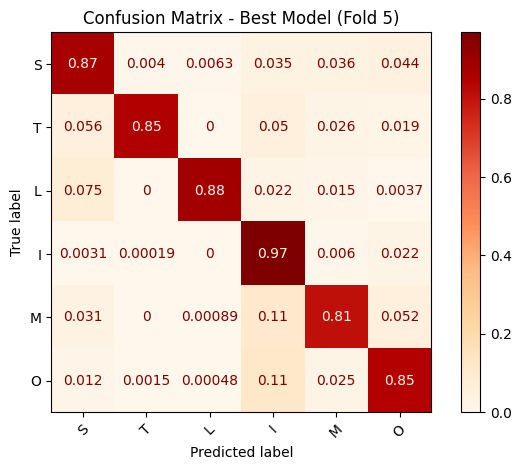

In [29]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

# Load best model
model = SPCNNClassifier(num_aa, NUM_CLASSES).to(DEVICE)

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
print(f"\nModel loaded from {MODEL_SAVE_PATH}")

model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        encoded_seq = batch['encoded_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF
        loss = model(encoded_seq=encoded_seq, attention_mask=attention_mask, labels=labels)
        test_loss += loss.item()

        # Decode predictions using CRF
        predictions = model(encoded_seq=encoded_seq, attention_mask=attention_mask)

        # Collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())

# Calculate metrics
print("\n" + "="*60)
print("Test Set Results")
print("="*60)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

f1_weighted = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
token_acc = accuracy_score(all_labels, all_preds)
seq_acc = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
avg_loss = test_loss / len(test_loader)

print(f"\nMetrics Summary:")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Token-level Accuracy: {token_acc:.4f}")
print(f"Sequence Level Accuracy: {seq_acc:.4f}")
print(f"Average test loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
cm_relative = cm.astype("float") / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=list(label_map.keys()))
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title(f"Confusion Matrix - Best Model (Fold {best_fold_num})")
plt.tight_layout()
plt.show()

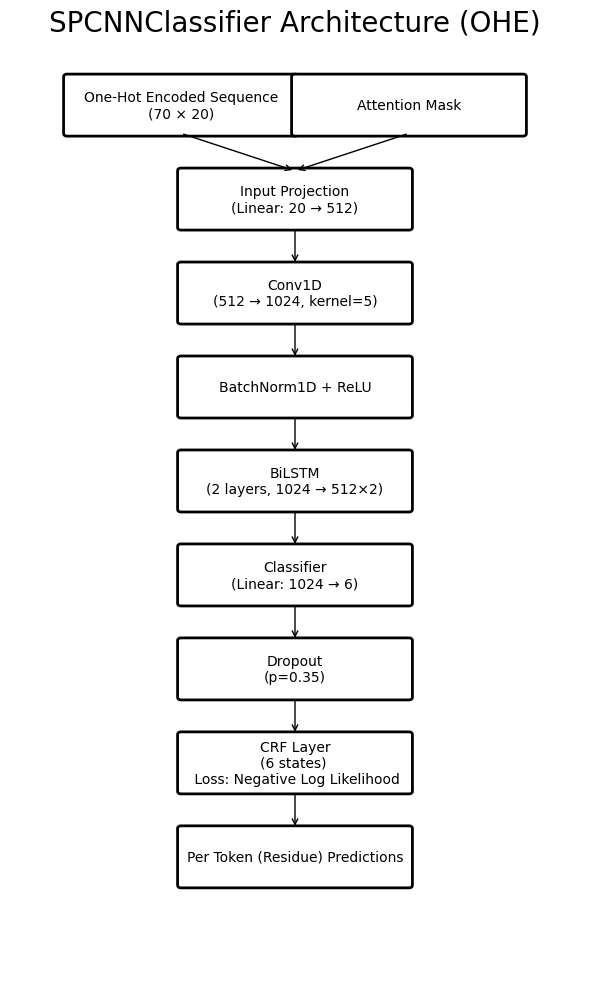

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_vertical_model():
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.axis('off')

    # Define blocks with (x, y)
    blocks = [
        ("One-Hot Encoded Sequence\n(70 × 20)", 0.5, 9.0),
        ("Attention Mask", 2.5, 9.0),
        ("Input Projection\n(Linear: 20 → 512)", 1.5, 8.0),
        ("Conv1D\n(512 → 1024, kernel=5)", 1.5, 7.0),
        ("BatchNorm1D + ReLU", 1.5, 6.0),
        ("BiLSTM\n(2 layers, 1024 → 512×2)", 1.5, 5.0),
        ("Classifier\n(Linear: 1024 → 6)", 1.5, 4.0),
        ("Dropout\n(p=0.35)", 1.5, 3.0),
        ("CRF Layer\n(6 states) \n Loss: Negative Log Likelihood", 1.5, 2.0),
        ("Per Token (Residue) Predictions", 1.5, 1.0)
    ]

    box_width = 2.0
    box_height = 0.6

    # Draw blocks
    for label, x, y in blocks:
        rect = mpatches.FancyBboxPatch((x, y), box_width, box_height, boxstyle="round,pad=0.03",
                                       edgecolor='black', facecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y + box_height / 2, label, ha='center', va='center', fontsize=10)

    # Draw arrows
    for i in range(2, len(blocks) - 1):  # skip input sequence and mask arrows
        x1 = blocks[i][1] + box_width / 2
        y1 = blocks[i][2]
        y2 = blocks[i+1][2] + box_height
        ax.annotate('', xy=(x1, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw arrows from inputs
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(0.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(2.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.title("SPCNNClassifier Architecture (OHE)", fontsize=20)
    plt.ylim(0, 10)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()

draw_vertical_model()